In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras.backend as K

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Softmax
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.utils.np_utils import to_categorical   
from keras.layers import Embedding
from keras.metrics import sparse_top_k_categorical_accuracy


In [2]:
# TO RUN YOUR CODE WITH DATA ON GOOGLE DRIVE
# Mount Google Drive so that we can load data
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# data_dir = 'drive/MyDrive/ECE542/Proj-F/data_processing/slices/'

# TO RUN YOUR CODE WITH DATA ON YOUR COMPUTER
data_dir = 'data_processing/slices/'


In [3]:
class KerasBatchGenerator(object):
    suffix = dict(
      artists='artists.csv',
      tracks='tracks.csv',
      albums='albums.csv',
      durations='durations.csv',
    )
    suffix2 = dict(
      artists='artists_2.csv',
      tracks='tracks_2.csv',
      albums='albums_2.csv',
      durations='durations_2.csv',
    )
    def __init__(self, files, max_seq_len, batch_size=1):
      self.files = files
      self.max_seq_len = max_seq_len
      self.batch_size = batch_size
      self.current_idx = 0
      self.rs = np.random.RandomState(seed=0)

    def set_max_seq_len(self, max_seq_len):
      self.max_seq_len = max_seq_len

    @staticmethod
    def truncate_pad(x, size):
      if len(x) >= size:
        return x[:size]
      else:
        return np.concatenate([np.zeros(size-len(x)).astype(x.dtype), x])

    @staticmethod
    def convert(df, max_seq_len):
      seq = np.array(list(df.groupby('pid').apply(lambda x: KerasBatchGenerator.truncate_pad(x.values.reshape(-1), max_seq_len+1))))
      return seq[:, :max_seq_len], seq[:, -1:]

    def load_file(self, f):
      artists = pd.read_csv(os.path.join(f, self.suffix['artists']))
      tracks = pd.read_csv(os.path.join(f, self.suffix['tracks']))
      albums = pd.read_csv(os.path.join(f, self.suffix['albums']))
      durations = pd.read_csv(os.path.join(f, self.suffix['durations']))

      artists = artists.set_index(['pid', 'pos'])
      tracks = tracks.set_index(['pid', 'pos'])
      albums = albums.set_index(['pid', 'pos'])
      durations = durations.set_index(['pid', 'pos'])

      return artists, tracks, albums, durations

    def get_data(self, file):
      # get the amount of data equals to the batch_size
      artists, tracks, albums, durations = self.load_file(file)

      artists, _ = self.convert(artists, self.max_seq_len)
      albums, _ = self.convert(albums, self.max_seq_len)
      tracks_x, tracks_y = self.convert(tracks, self.max_seq_len)
      durations, _ = self.convert(durations, self.max_seq_len)  

      return {
          'albums': albums,
          'artists': artists,
          'tracks': tracks_x,
          'durations': durations,
          'tracks_y': tracks_y
          # 'sample_candidate': np.repeat(np.random.choice(list(range(528646-1)), size=100000, replace=False), repeats=len(train_tracks_x))
      }  


    def pre_write_data(self):
      """
      Only run once to convert data to 2-D format. 
      """
      for f in tqdm(self.files, desc="Loading files."):
        output = self.get_data(f)
        output['durations'] = output['durations'] / 60000   # convert to minutes
        for k, v in self.suffix2.items():
          fmt = '%.2f' if k == 'durations' else '%i'
          np.savetxt(os.path.join(f, v), output[k], delimiter=",", fmt=fmt)

    def load_pre_written_data(self, f):
      output = {}
      for k, v in self.suffix2.items():
        data = np.loadtxt(os.path.join(f, self.suffix2[k]), delimiter=",")
        size = min(data.shape[1]-1, self.max_seq_len) # -1 to make sure we have one y value
        output[k] = data[:, :size]
        if k == 'tracks':
          output['tracks_y'] = data[:, [size]]
      return output

    def generate(self):
        while True:
            # if the current_idx is outside of range, reset it to 0 and re-sample from begining
            if self.current_idx >= len(self.files):
                self.current_idx = 0
                # shuffle
                self.rs.shuffle(self.files)

            output = [self.load_pre_written_data(self.files[self.current_idx+i]) for i in range(self.batch_size)]
            x = {
                'albums': np.concatenate([d['albums'] for d in output], axis=0),
                'artists': np.concatenate([d['artists'] for d in output], axis=0),
                'tracks': np.concatenate([d['tracks'] for d in output], axis=0),
                'durations': np.concatenate([d['durations'] for d in output], axis=0)
                # 'sample_candidate': np.repeat(np.random.choice(list(range(528646-1)), size=100000, replace=False), repeats=len(train_tracks_x))
            }  

            y = np.concatenate([d['tracks_y'] for d in output], axis=0)

            self.current_idx += self.batch_size
            
            yield x, y

In [4]:
# Load and split training/validation data

# ! ls drive/MyDrive/ECE542/ECE542_sp2021_Project_TerrainRecognition/TrainingData/subject_001_01__x.csv
# step 1: get all files
files = glob.glob(os.path.join(data_dir, '*/'))
files = np.array(files)


# step 2: split training/validation data by files
rs = np.random.RandomState(seed=1)
train_index = np.linspace(0, 1, num=len(files)) > 0.01
rs.shuffle(train_index)

# step 3: create training/validation data generator
print("Creating training data generator")
train_data_generator = KerasBatchGenerator(files=files[train_index], max_seq_len=51, batch_size=1)
print("Creating validation data generator")
valid_data_generator = KerasBatchGenerator(files=files[~train_index], max_seq_len=51, batch_size=1)

print(files[train_index][:2])
# train_data_generator.pre_write_data()
# valid_data_generator.pre_write_data()
train_data_generator.set_max_seq_len(20)
valid_data_generator.set_max_seq_len(20)

np.sum(train_index), train_index.shape

Creating training data generator
Creating validation data generator
['data_processing/slices/93000-93999/'
 'data_processing/slices/489000-489999/']


(990, (1000,))

In [5]:
files[0:2]

array(['data_processing/slices/93000-93999/',
       'data_processing/slices/489000-489999/'], dtype='<U37')

In [6]:
class SimpleLSTMModel(tf.keras.Model):
  def __init__(self, embed_size, max_seq_len, rate_dropout):
    super().__init__()
    self.embed_size = embed_size
    self.max_seq_len = max_seq_len
    self.rate_dropout = rate_dropout

    self.embedding_albums = Embedding(input_dim=273307, output_dim=self.embed_size)
    self.embedding_artists = Embedding(input_dim=110412, output_dim=self.embed_size)
    self.embedding_tracks = Embedding(input_dim=528646, output_dim=self.embed_size)
    self.lstm = LSTM(units=self.embed_size, input_shape=(None, None, self.embed_size), return_sequences=False)
    self.dropout = Dropout(rate=self.rate_dropout)
    self.dense = Dense(self.embed_size, activation='relu')
    self.softmax = Softmax()

  def call(self, input):
    alb = input.get('albums')
    art = input.get('artists')
    trk = input.get('tracks')
    # sample_candidate = input.get('sample_candidate')

    # get embedding
    em_alb = self.embedding_albums(alb)
    em_art = self.embedding_artists(art)
    em_trk = self.embedding_tracks(trk)

    # fusion layer
    fusion = em_alb * em_art * em_trk

    # LSTM
    hidden = self.lstm(fusion[:, -self.max_seq_len:, :])
    hidden = self.dropout(hidden)
    hidden = self.dense(hidden)

    # recommend by choosing from a sampled subset
    logit = tf.matmul(hidden, tf.transpose(self.embedding_tracks.embeddings))
    # em_sample = self.embedding_tracks(sample_candidate)
    # logit = tf.matmul(hidden, tf.transpose(em_sample))
    logit = self.softmax(logit)

    return logit


model = SimpleLSTMModel(embed_size=30, max_seq_len=20, rate_dropout=0.1)

def top_5_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=5)

def top_10_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=10)

def top_20_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=20)


lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps=1000,
                               decay_rate=0.95)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=[top_5_accuracy, top_10_accuracy, top_20_accuracy])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)



history_LSTM = model.fit_generator(generator=train_data_generator.generate(),
                                   steps_per_epoch=min(len(train_data_generator.files), 20),
                                   epochs=300,
                                   callbacks=[es],
                                   validation_data=valid_data_generator.generate(),
                                   validation_steps=len(valid_data_generator.files))

/Users/jliu/miniconda3/envs/homework/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
20/20 [==============================] - 86s 4s/step - loss: 13.1754 - top_5_accuracy: 0.0475 - top_10_accuracy: 0.0574 - top_20_accuracy: 0.0722 - val_loss: 13.1499 - val_top_5_accuracy: 0.3480 - val_top_10_accuracy: 0.3480 - val_top_20_accuracy: 0.3480

In [7]:
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy - top 5
    plt.title('Accuracy - Top 5')
    plt.plot(history.history['top_5_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_top_5_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy - top 10
    plt.title('Accuracy - Top 10')
    plt.plot(history.history['top_10_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_top_10_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy - top 20
    plt.title('Accuracy - Top 20')
    plt.plot(history.history['top_20_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_top_20_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()



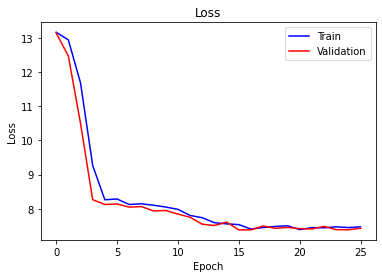

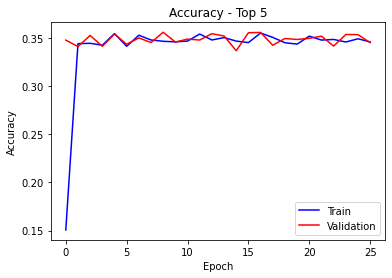

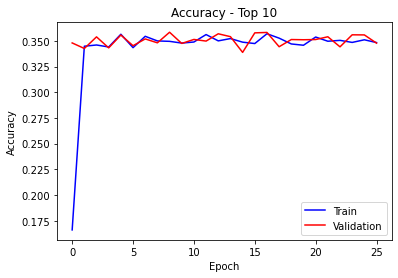

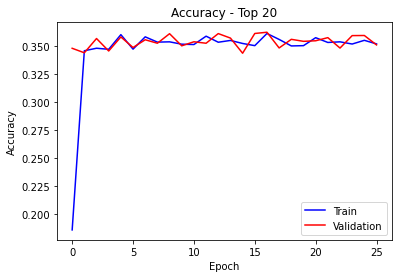

In [8]:
plot_history(history_LSTM)